In [1]:
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load the notes used to train the model
with open('/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/vocabulary/vocabulary', 'rb') as filepath:
    notes = pickle.load(filepath)

In [4]:
 # Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

In [5]:
#prepare the possible sequences to start from

# map between notes and integers and back
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

sequence_length = 100
network_input = []
output = []
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
normalized_input = normalized_input / float(n_vocab)

In [7]:
#re-create the network initializing its weights with the pretrained ones
model = Sequential()
model.add(LSTM(
              int(n_vocab),
              input_shape=(normalized_input.shape[1], normalized_input.shape[2]),
              return_sequences=True,
              ))

model.add(LSTM(int(n_vocab/2)))

model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Load the weights to each node
model.load_weights('/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/model/chopin-model.hdf5')

Generate notes

In [8]:
  # pick a random sequence from the input as a starting point for the prediction
  start = numpy.random.randint(0, len(network_input)-1)

  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

  pattern = network_input[25345]
  prediction_output = []

  #save a probability here, useful just for the documentation
  probability_distribution = None

  id_notes = numpy.arange(0, n_vocab)
  # generate 500 notes
  for note_index in range(500):
      prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
      prediction_input = prediction_input / float(n_vocab)

      prediction_probabilities = model.predict(prediction_input, verbose=0)

      #for the documentation
      probability_distribution = prediction_probabilities[0]

      index = numpy.random.choice(id_notes,1, p = prediction_probabilities[0])
      #print(index)
      result = int_to_note[index[0]]
      prediction_output.append(result)

      pattern.append(index[0])
      pattern = pattern[1:len(pattern)]

Create midi files from predicted notes

In [9]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/music generated/AI_RNN_Chopin_music_2.midi')

'/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/1. First architecture for polyphonic music/music generated/AI_RNN_Chopin_music_2.midi'

In [ ]:
numpy.max(probability_distribution)

Text(0.5, 0, 'Data')

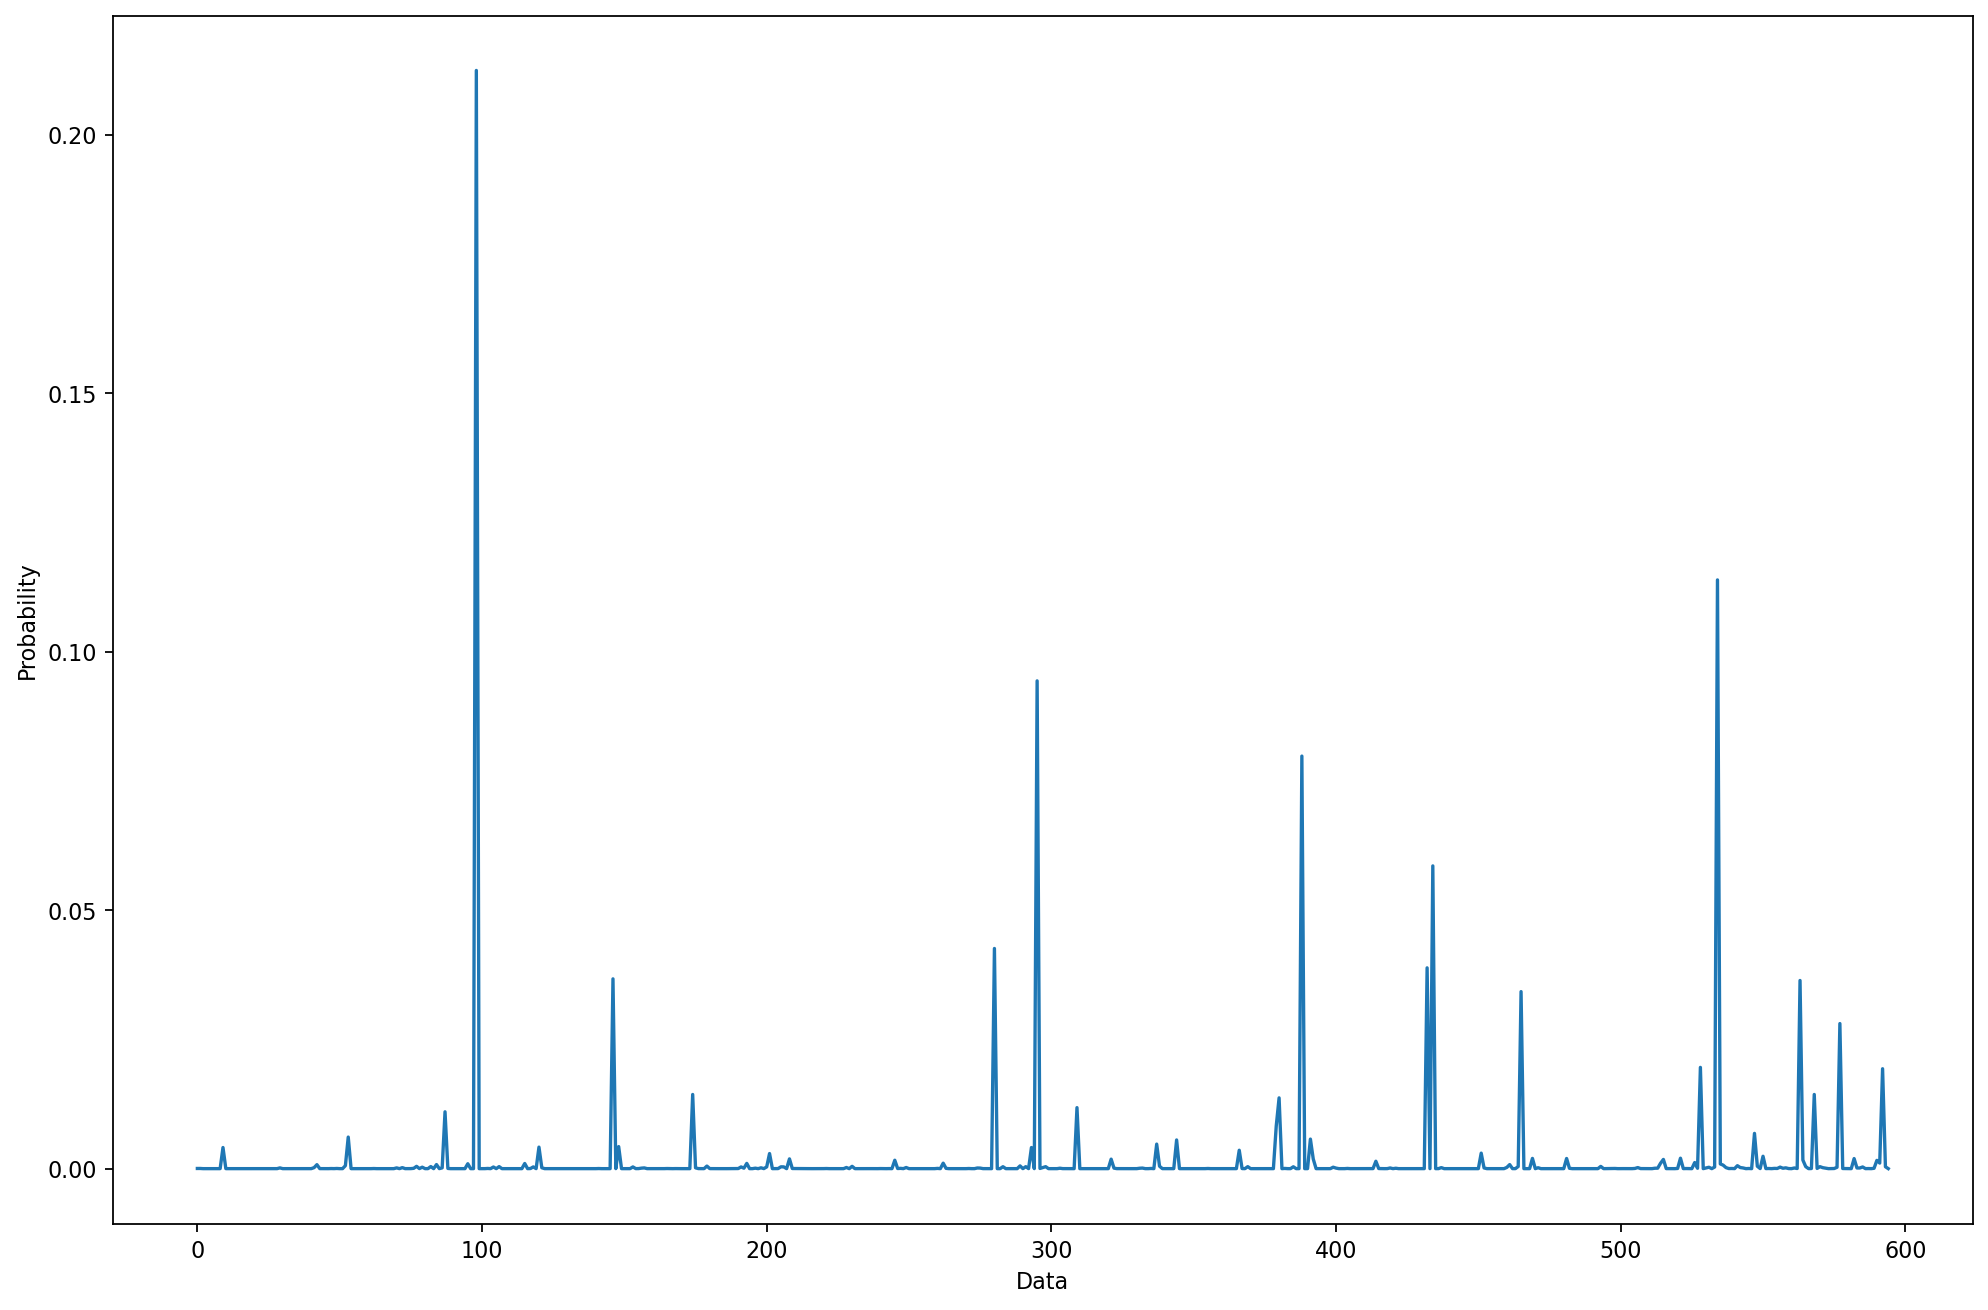

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)

plt.plot(probability_distribution)  
plt.ylabel('Probability')
plt.xlabel('Data')